In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install yellowbrick

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


#### To randomly fetch 720 text-based tweets from the original dataset, kindly follow the instructions:
1. Install MySQL on the local machine
2. Configure local MySQL server with user = 'root', password = 'admin', and database = 'tweetsdb'
3. Load Dump20170424-3.sql on your MySQL database
4. Execute the code for pooling tweets, but ensure the executor with the permission to access the local disk 

In [ ]:
import os
import mysql.connector

def dataFlash(path, dirName):
    os.chdir(path)
    # Note that the operation is required to system permission
    # Kindly ensure that you have granted the access to the current operation
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    else:   
        os.remove(dirName)
    pass

# Please make sure you are the Administrators, otherwise, you may 
# PermissionError: [WinError 5] Access is denied: 'dataset'

def dataPooling(path, dirName):
    mydb = mysql.connector.connect(
      host="localhost",
      user="root",
      password="admin",
      database="tweetsdb"
    ) # DB Configuration
    
    # Data Query
    cursor = mydb.cursor() 
    cursor.execute(" SELECT U.ID, U.SCREEN_NAME, T.TEXT FROM TWEETSDB.TWEETS T, \
                    (SELECT USER.ID AS ID, USER.SCREEN_NAME AS SCREEN_NAME \
                    	FROM TWEETSDB.USER USER, \
                    	(SELECT USER FROM TWEETSDB.TWEETS GROUP BY USER HAVING COUNT(TEXT) >= 1 LIMIT 720) T \
                        WHERE USER.ID = T.USER) U \
                        WHERE T.USER = U.ID ORDER BY T.USER ")
    results = cursor.fetchall() 
    
    # 1284 Records
    print("Total Tweets ", len(results))
    # {id:[NAME, TWEET1, TWEET2 ...]}
    col = {}
    for result in results:
        u_id   = result[0]
        u_name = result[1]
        tweet  = result[2]
        if u_id in col:
            col[u_id].append(tweet)
        else:
            col[u_id] = [u_name]
            col[u_id].append(tweet)
            
    # Pooling to documents by applying User-Pooling Technique
    for id, texts in col.items():
        with open(path + dirName + "/" + str(id) + '.txt' ,'w+', encoding='utf-8') as f:
            text  = "<uid>"   + str(id) + "\n"
            for i in range(len(texts)):
                if(i == 0):
                    text += "<uname>" + texts[i] + "\n" + "<tweet>" + "\n"  # U_NAME
                else:
                    text += texts[i] + "\n"
            f.write(text)
        f.close()

In [ ]:
path = './'
dirName = 'dataset'
dataFlash(path, dirName)
dataPooling(path, dirName)


# If the dataset is ready for access, kindly ignore the code.

In [3]:
import os
import re, string
import nltk

from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.corpus import wordnet
from nltk.stem   import WordNetLemmatizer
from nltk.tokenize  import word_tokenize
from nltk import SnowballStemmer

import scipy.cluster.hierarchy as hi
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from wordcloud import WordCloud
import time

In [4]:
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\n10306986\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\n10306986\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\n10306986\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
def output(classifier, silhouette_avg, n_cluster, time):
    print("{}: Avg: {}  K: {} time(sec): {}".format(classifier, silhouette_avg.round(4), n_cluster, time))

def num_clusters(X, labels):
    for k in set(labels):
        ids = np.where(labels == k)
        cluster = X[ids]
        print("Cluster {}, with the numbers = {}".format(k, len(cluster)))

In [28]:
def pre_process(inputpath):
    col    = {}
    lemmatizer = WordNetLemmatizer()
    v_dir = os.listdir(inputpath)
    for file in v_dir:
        tweets = []
        uname  = ""
        fname  = inputpath + file
        
        fo = open(fname, mode='r', encoding='utf-8')
        lines = fo.read().split('\n')
        stemmer = SnowballStemmer("english")
        
        for text in lines:
            corpus = ""
            if text == "": continue
            
            if(text.startswith('<uid>')): continue
            elif(text.startswith('<uname>')):
                uname = text.replace("<uname>", "").strip()
                continue
            elif(text.startswith('<tweet>')): continue
            else:
                # Eliminate non English tweets [ASCII Decimal 0 - 127]
                text = ''.join([i if ord(i) < 128 else '' for i in text]) 
                
                # Remove 'RT' & '&amp;'
                text = text.replace('RT', '').replace('&amp;', '')
                
                # Erase user mentions and URLs
                text = re.sub(r"http\S+","", text)
                text = re.sub(r"\S*\d\S*","", text)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
                text = re.sub(r"\S*@\S*\s?","", text) # removes emails and mentions (words with @)
                text = re.sub(r"www\S+", "", text)    # removes URLs 
                
                # Eliminate punctuation (contains #) & digits
                text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
                text = text.translate(str.maketrans('','', string.digits))
                
                # Convert to lowercase
                text = text.casefold() 
                
                # Keep a space between words
                text = " ".join(text.split())
                
                listOfTokens = word_tokenize(text)
                
                if len(listOfTokens) <= 3: continue
            
                for term in listOfTokens: 
                    # Remove terms that are in the bag of stop-words & Length < 3
                    if len(term) >= 3 :
                        if term not in stopwords.words('english'):
                            # Terms Lemmatization
                            term = lemmatizer.lemmatize(term, pos='v')
                            if len(term) >= 4 :
                                # term = stemmer.stem(term)
                                corpus += term + ' '
                            else:
                                continue
                tweets.append(corpus.strip())
        #col[uname] = corpus.strip()
        col[uname] = tweets
        fo.close()  
    return col

In [48]:
def Cal_KMeans(X, K):
   start = time.time()
   kmeans = KMeans(init = 'k-means++', random_state= 250, n_clusters = K).fit(X)
   end = time.time()
   return kmeans, (end-start)

def Cal_DBSCAN(X, eps, min_samples):
   start = time.time()
   db = DBSCAN(eps = eps, min_samples = min_samples, metric = 'euclidean', n_jobs = -1).fit(X)
   end = time.time()
   return db, (end-start)

def Cal_Agglomerative(X, K):
   start = time.time()
   agglomerative = AgglomerativeClustering(n_clusters=K, affinity = "euclidean").fit(X)
   end = time.time()
   return agglomerative, (end-start)

In [30]:
def plotClusterFeatures(X, labels, n_feats, features):
    labels = np.unique(labels)
    dfs = []
    for label in labels:
        ids = np.where(labels==label)                    # Tuple to store indexes of labels, 
        means = np.mean(X[ids], axis = 0)                # Returns average score from the current cluster
        sorted_means = np.argsort(means)[::-1][:n_feats] # Indices top-20 features by scores
        best_features = [(features[i], means[i]) for i in sorted_means]
        print(best_features)
        df = pd.DataFrame(best_features, columns = ['features', 'Average Weight Score'])
        plt.figure(figsize=(8, 4))
        plt.title(("Most Common Words in Cluster {}".format(label)), fontsize=12, fontweight='bold')
        sns.barplot(x = 'Average Weight Score' , y = 'features', orient = 'h' , data = df[:n_feats])
        plt.show()

In [31]:
def plotClusterFeatures2(df, labels, n_feats):
    wordBag    = []
    collection = []
    docFreq    = dict()
    
    labels2     = np.unique(labels)

    for label in labels2: 
        a_index = -1
        mx = []
        for mmm in labels:
            a_index += 1
            if label == mmm:
                mx.append(a_index)
        
        for index in mx:
            index = int(index)
            collection.append(df['tweet'].iloc[index])

        for tweet in collection:
            for word in tweet.split():
                if word not in wordBag:
                    wordBag.append(word)

        for term in wordBag:
            docFreq[term] = 0

        for term in wordBag:
            for tweet in collection:
                if term in tweet:
                    docFreq[term] += 1

        docFreq = dict(sorted(docFreq.items(), key=lambda x: x[1], reverse=True))

        best_features = []
        for key, value in docFreq.items():
            best_features.append((key, value))

        #print(best_features)
        dataFrame = pd.DataFrame(best_features, columns = ['Features', 'Document Frequency'])
        plt.figure(figsize=(8, 4))
        plt.yticks(fontsize = 14)
        plt.title(("Most Common Words in Cluster {}".format(label)), fontsize=12, fontweight='bold')
        sns.barplot(x = 'Document Frequency' , y = 'Features', orient = 'h' , data = dataFrame[:n_feats])
        plt.show()

In [32]:
def plotClusterFeatures3(df, labels, n_feats):
    wordBag    = []
    collection = []
    docFreq    = dict()
    
    pp = 0
    labels2     = np.unique(labels)
    for label in labels2: 
        a_index = -1
        mx = []
        for mmm in labels:
            a_index += 1
            if label == mmm:
                mx.append(a_index)
        
        for index in mx:
            index = int(index)
            collection.append(df['tweet'].iloc[index])

        for tweet in collection:
            for word in tweet.split():
                if word not in wordBag:
                    wordBag.append(word)

        for term in wordBag:
            docFreq[term] = 0

        for term in wordBag:
            for tweet in collection:
                if term in tweet:
                    docFreq[term] += 1

        docFreq = dict(sorted(docFreq.items(), key=lambda x: x[1], reverse=True))
        
        best_features = []
        for key, value in docFreq.items():
            best_features.append((key, value))

        #print(best_features)
        dataFrame = pd.DataFrame(best_features, columns = ['Features', 'Document Frequency'])
        plt.figure(figsize=(8, 4))
        plt.yticks(fontsize = 14)
        plt.title(("Most Common Words in Cluster {}".format(label)), fontsize=12, fontweight='bold')
        sns.barplot(x = 'Document Frequency' , y = 'Features', orient = 'h' , data = dataFrame[:n_feats])
        plt.show()
        
        if pp == 9:
            break
        else:
            pp += 1

In [51]:
def generateWordCloudsKMeans(centroids, col):
    centroid_dict = dict()
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        rows = centroids.T[i].sort_values(ascending = False).reset_index().values
        for j in range(0, len(rows)):
            centroid_dict.update( {rows[j,0] : rows[j,1]} )

        centroid_dict = dict(sorted(centroid_dict.items(), key=lambda x: x[1], reverse=True))
        #print(centroid_dict)
        
        user_intest = {}
        for name, tweets in col.items():
            weight = 0.0
            for tweet in tweets:
                for word in tweet.split():
                    if word in centroid_dict:
                        weight += centroid_dict[word]
            user_intest[name] = round(weight,2)   
        user_intest = dict(sorted(user_intest.items(), key=lambda x: x[1], reverse=True))
        
        new_user_intest = {}
        
        for name, weight in user_intest.items():
            if weight > 0.0:
                new_user_intest[name] = weight
        print(new_user_intest)
       
        if len(new_user_intest) > 0:
            wordcloud.generate_from_frequencies(new_user_intest)
            plt.figure()
            plt.title('Cluster {} - User Group'.format(i))
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.show()

In [52]:
def generateWordCloudsDBSCAN(centroids, col, n_cluster):
    centroid_dict = dict()
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        rows = centroids.T[i].sort_values(ascending = False).reset_index().values
        for j in range(0, len(rows)):
            centroid_dict.update( {rows[j,0] : rows[j,1]} )
            centroid_dict = dict(sorted(centroid_dict.items(), key=lambda x: x[1], reverse=True))
    #print(centroid_dict)
    
    user_intest = {}
    for name, tweets in col.items():
        weight = 0.0
        for tweet in tweets:
            for word in tweet.split():
                if word in centroid_dict:
                    weight += centroid_dict[word]
        user_intest[name] = round(weight, 2)   
    user_intest = dict(sorted(user_intest.items(), key=lambda x: x[1], reverse=True))

    new_user_intest = {}
    for name, weight in user_intest.items():
        if weight > 0.0:
            new_user_intest[name] = weight
    print(new_user_intest)
    
    if len(new_user_intest) > 0:
        wordcloud.generate_from_frequencies(new_user_intest)
        plt.figure()
        plt.title('Cluster {} - User Group'.format(n_cluster))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [35]:
def silhouetteEval(X, labels):
    silhouette_avg = 0.0
    unique_labels = set(labels)
    if len(unique_labels) == 1:
        print("the number of labels are less than 1")
    else:
        silhouette_avg = round(silhouette_score(X, labels), 4) 
    return silhouette_avg

In [36]:
def get_TFIDF_Matrix(col):
    corpus = [] 
    users  = []
    for name, tweets in col.items():
        for tweet in tweets:
            corpus.append(tweet)
            users.append(name)
    vectorizer = TfidfVectorizer(max_features = 800, min_df = 10) # , min_df = 10 max_features = 800, min_df = 20
    X = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names()

    data = {"user": users, "tweet": corpus}
    df = pd.DataFrame(data)
    
    matrix = pd.DataFrame(data = X.toarray(), columns = features)
    matrix['user']= df['user']
    matrix['tweet']= df['tweet']
    print("n_samples: %d, n_features: %d" % X.shape)
    return (matrix, features)

In [37]:
def silhouettePlot(X, n_clusters, labels, silhouette_avg, classifer):
    fig, ax1 = plt.subplots(1)  # Create a subplot with 1 row
    fig.set_size_inches(14, 12)   # Define the size for the subplot
    
    plt.xticks(fontsize=14)
    ax1.set_xlim([-0.05, 0.3])                            # Limit the range to X-axis
    ax1.set_xticks([-0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]) # Scale X-axis
    ax1.set_xlabel("Silhouette Coefficient Values", fontsize = 14)  # Title for X-axis
        
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_yticks([])                              # Clear the yaxis labels / ticks
    ax1.set_ylabel("Cluster label",  fontsize = 14)      # Title for Y-axis
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x = silhouette_avg, color="red", linestyle="--") 
    plt.title(("Silhouette Analysis for %s with K = %d" % (classifer, n_clusters)), fontsize=14, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(X, labels, metric='euclidean') # Compute the silhouette scores for each sample
    
    i = 0
    numLabels = np.unique(labels)
    for label in numLabels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == label]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                              facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label), fontsize = 14) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10                                                           # Compute the new y_lower for next plot. 10 for the 0 samples
        i += 1
    plt.show()

In [43]:
n_feats = 15
inputpath = "./dataset/"
col = pre_process(inputpath)
df, features = get_TFIDF_Matrix(col)
matrix = df.drop(['user', 'tweet'], axis=1)

X = matrix.to_numpy()
num_samples = X.shape[0]
num_features = X.shape[0]
print(col)
# https://nbviewer.jupyter.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

n_samples: 2627, n_features: 307
{'TeamOfGriers': ['dear single girls read feel miss really beautiful amaze girl', 'drive husband years alaylm start radio', 'justin stop sing tonight pray give idol'], 'MaPapathanasiou': ['happy birthday axwell keep good music greet greece'], 'iamsrk': ['young boys girls follow wheelers wave scream please please careful scar', 'raindrops window pane miss family happy wife baby london soon heart need warmth', 'know french tell cover apart name thanx', 'dont ocean teaspoon take along bucket allah deliver hold back today health'], 'Dion_Live': ['actor model singer david dion collier make appearance boss starz dionlive teamdionstarr'], 'rohtalks': ['know iphone help people lose weight afford month', 'warm breeze whisper', 'open window', 'skip across lake'], 'laughposts': ['never angry stay awake plot revenge', 'someone drivers liscence beat rainbow road mario kart without fall', 'love something come back visit hunt kill'], 'KEVINGETEM': ['idontunderstandwhy

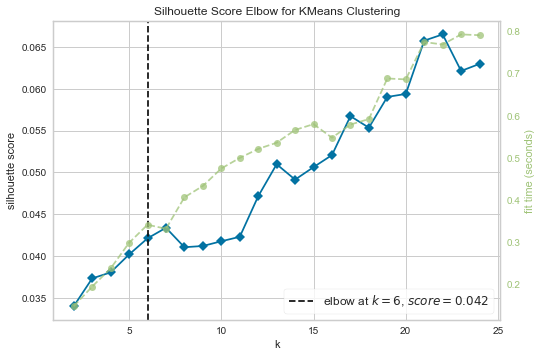

In [42]:
max_k   = 25
kmeans  = KMeans(init = 'k-means++', random_state= 250)
visualizer = KElbowVisualizer(kmeans, metric='silhouette', k=(2, max_k), timings=True, locate_elbow=True)
K = visualizer.fit(matrix).elbow_value_
visualizer.show()

In [44]:
from yellowbrick.cluster import SilhouetteVisualizer

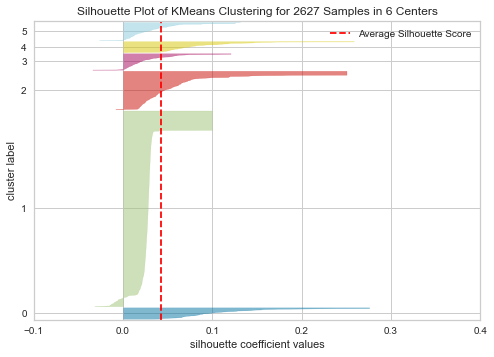

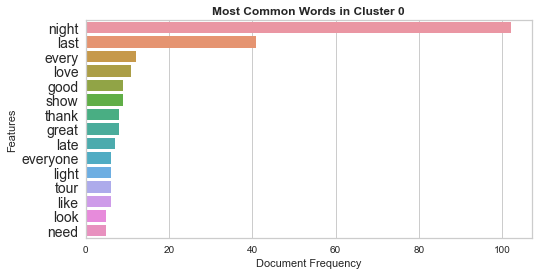

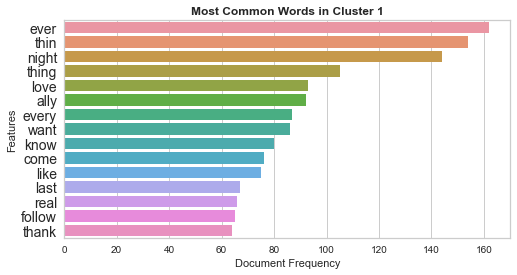

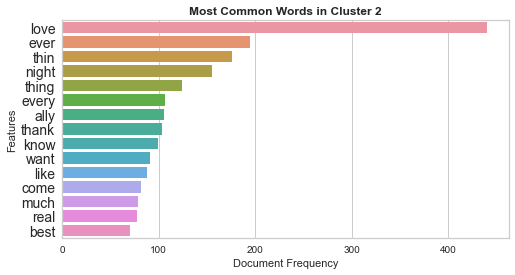

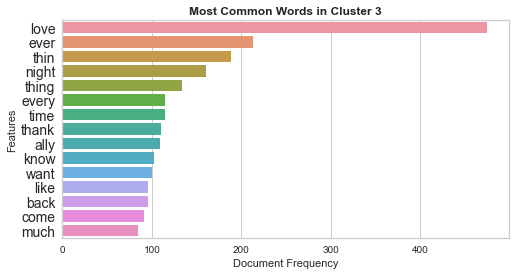

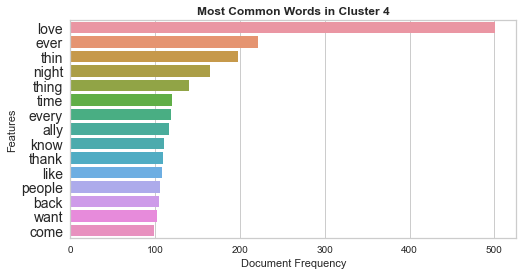

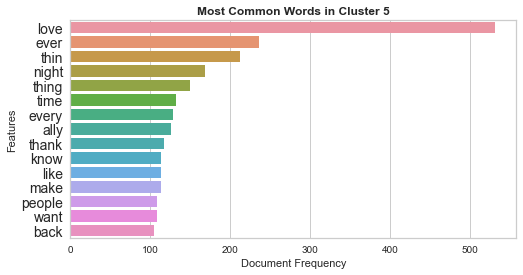

{'justinbieber': 7.95, 'NiallOfficial': 5.08, 'XSTROLOGY': 3.42, 'Louis_Tomlinson': 2.9, 'ddlovato': 2.55, 'ArianaGrande': 2.25, 'NICKIMINAJ': 2.15, 'taylorswift13': 2.06, 'Complex': 2.02, 'autocorrects': 2.02, 'zaynmalik': 1.92, 'babetexts': 1.84, 'Harry_Styles': 1.78, 'LittleMix': 1.63, 'damnitstrue': 1.59, 'TheFactsBook': 1.51, 'RealHughJackman': 1.39, 'katyperry': 1.38, 'LaurenCimorelli': 1.33, 'LiamPayne': 1.29, 'AlfredoFlores': 1.21, 'carlyraejepsen': 1.16, 'aew9': 1.14, 'TomFletcher': 1.13, 'MirandaCosgrove': 1.1, 'selenagomez': 1.06, 'MTV': 1.05, 'MindBlowing': 1.03, 'JaredLeto': 1.02, 'Jenny_OMalley': 0.98, 'WoWFactz': 0.91, 'DaniellePeazer': 0.9, 'ninadobrev': 0.9, 'JoshDevineDrums': 0.86, 'Brittanysnow': 0.86, 'chordoverstreet': 0.83, 'RobertsEmma': 0.82, 'TheVampsband': 0.82, 'MileyCyrus': 0.81, 'SimonCowell': 0.81, 'FreddyAmazin': 0.79, 'mrtruthandsoul': 0.77, 'travismills': 0.76, 'sarahfletchh': 0.76, 'torrami': 0.76, 'NormaniKordei': 0.74, 'Juan_Golbezze': 0.74, 'LILBTHE

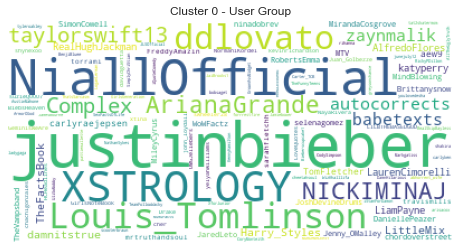

{'XSTROLOGY': 3.16, 'justinbieber': 2.96, 'damnitstrue': 1.25, 'NiallOfficial': 1.05, 'ddlovato': 1.04, 'autocorrects': 0.93, 'babetexts': 0.89, 'GirlsNoteBook': 0.78, 'Louis_Tomlinson': 0.77, 'ArianaGrande': 0.7, 'FreddyAmazin': 0.68, 'zaynmalik': 0.62, 'NICKIMINAJ': 0.6, 'LoveQuotes': 0.51, 'CodySimpson': 0.49, 'WizKhalllifa': 0.48, 'BiebsHeaven': 0.47, 'LILBTHEBASEDGOD': 0.47, 'LittleMix': 0.46, 'MTV': 0.44, 'DamnHiIarious': 0.44, 'LiamPayne': 0.43, 'Harry_Styles': 0.43, 'selenagomez': 0.41, 'ThatsSarcasm': 0.4, 'iQuoteComedy': 0.37, 'ladygaga': 0.36, 'TheFunnyTeens': 0.36, 'RealSkipBayless': 0.33, 'scooterbraun': 0.32, 'JaiBrooks1': 0.31, 'JaredLeto': 0.29, 'TheFactsBook': 0.28, 'TeamFollowWacky': 0.28, 'AustinMahone': 0.27, 'MindBlowing': 0.27, 'KennyHamilton': 0.26, 'taylorswift13': 0.26, 'MileyCyrus': 0.26, 'HEADLESSGANG': 0.25, 'katyperry': 0.24, 'BieberCokeFloat': 0.24, 'cher': 0.23, 'greysonchance': 0.23, 'iadorewomen_': 0.23, 'XforJunior': 0.23, 'RealHughJackman': 0.23, 'Rob

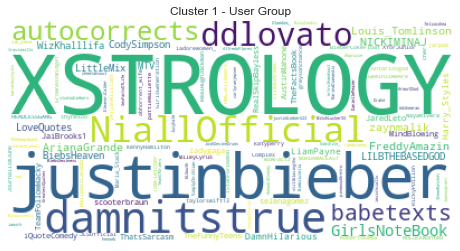

{'justinbieber': 17.07, 'XSTROLOGY': 16.9, 'NiallOfficial': 8.3, 'babetexts': 7.32, 'LILBTHEBASEDGOD': 7.24, 'ddlovato': 6.93, 'LoveQuotes': 6.64, 'ArianaGrande': 6.09, 'damnitstrue': 5.99, 'zaynmalik': 5.67, 'LiamPayne': 4.69, 'WizKhalllifa': 4.18, 'FreddyAmazin': 3.89, 'autocorrects': 3.7, 'Louis_Tomlinson': 3.56, 'iStanForDamon': 3.51, 'RobertsEmma': 3.18, 'GirlsNoteBook': 3.17, 'JaredLeto': 3.12, 'NICKIMINAJ': 2.62, 'SimplyChri5tian': 2.58, 'CodySimpson': 2.51, 'ladygaga': 2.44, 'MileyCyrus': 2.43, 'TheFunnyTeens': 2.42, 'pattiemallette': 2.28, 'LittleMix': 2.11, 'selenagomez': 2.06, 'JaiBrooks1': 1.97, 'greysonchance': 1.9, 'BiebsSexiness': 1.87, 'ECHOisthename': 1.77, 'BWaldorfQuotes': 1.74, 'Harry_Styles': 1.67, 'KennyHamilton': 1.6, 'ThatsSarcasm': 1.58, 'JLSOfficial': 1.52, 'TheFactsBook': 1.49, 'ontariosgod': 1.48, 'JoshDevineDrums': 1.47, 'HEADLESSGANG': 1.47, 'NayaRivera': 1.43, 'studiobiebers': 1.42, 'DaniellePeazer': 1.41, 'GeminisWeAre': 1.41, 'camilacabello97': 1.39, 'M

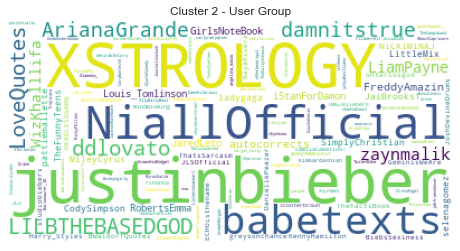

{'justinbieber': 8.44, 'XSTROLOGY': 5.73, 'NiallOfficial': 3.19, 'ddlovato': 2.93, 'damnitstrue': 2.82, 'LoveQuotes': 2.44, 'zaynmalik': 2.22, 'babetexts': 2.16, 'ArianaGrande': 2.02, 'CodySimpson': 2.0, 'autocorrects': 1.99, 'Louis_Tomlinson': 1.87, 'LILBTHEBASEDGOD': 1.78, 'GirlsNoteBook': 1.7, 'DamnHiIarious': 1.48, 'FreddyAmazin': 1.39, 'WizKhalllifa': 1.15, 'BiebsHeaven': 1.12, 'greysonchance': 0.94, 'LiamPayne': 0.91, 'LittleMix': 0.91, 'shynexoo': 0.9, 'selenagomez': 0.89, 'ontariosgod': 0.88, 'TheFactsBook': 0.88, 'JaredLeto': 0.87, 'iadorewomen_': 0.84, 'Harry_Styles': 0.84, 'BieberCokeFloat': 0.81, 'iStanForDamon': 0.79, 'NICKIMINAJ': 0.79, 'ThatsSarcasm': 0.76, 'WoWFactz': 0.76, 'XforJunior': 0.75, 'MileyCyrus': 0.74, 'JaiBrooks1': 0.73, 'katyperry': 0.72, 'scooterbraun': 0.69, 'SimplyChri5tian': 0.69, 'TomFletcher': 0.68, 'TheFunnyTeens': 0.67, 'KennyHamilton': 0.66, 'ladygaga': 0.63, 'AustinMahone': 0.61, 'MURDAMALEASY': 0.6, 'chordoverstreet': 0.6, 'AstrologyTaurus': 0.59

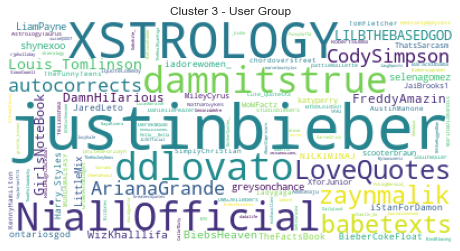

{'XSTROLOGY': 7.29, 'justinbieber': 6.31, 'autocorrects': 5.23, 'damnitstrue': 4.27, 'babetexts': 4.07, 'ddlovato': 3.45, 'LILBTHEBASEDGOD': 3.45, 'LoveQuotes': 2.14, 'zaynmalik': 2.09, 'GirlsNoteBook': 2.06, 'ArianaGrande': 2.04, 'NiallOfficial': 2.03, 'TheFactsBook': 2.0, 'MindBlowing': 1.94, 'WizKhalllifa': 1.74, 'FreddyAmazin': 1.62, 'boonepickens': 1.54, 'GrownAssMidget': 1.42, 'JournalismJunk': 1.25, 'Louis_Tomlinson': 1.22, 'ThatsSarcasm': 1.17, 'edsheeran': 1.17, 'TheDailySchmuck': 1.15, 'iexistniallx': 1.15, 'Harry_Styles': 1.1, 'RobertsEmma': 1.09, 'LiamPayne': 1.01, 'NICKIMINAJ': 0.98, 'Its_DesiPeach': 0.97, 'iadorewomen_': 0.95, 'GeminisWeAre': 0.94, 'scooterbraun': 0.91, 'ontariosgod': 0.9, 'ECHOisthename': 0.89, 'BiebsSexiness': 0.88, 'CodySimpson': 0.86, 'iQuoteComedy': 0.84, '99u': 0.83, 'WoWFactz': 0.83, 'AustinMahone': 0.8, 'MarinaDiamandis': 0.78, 'climaxdrews': 0.77, 'selenagomez': 0.76, 'RealHughJackman': 0.76, 'JaredLeto': 0.76, 'TheVampsband': 0.75, 'SexFactsOfLi

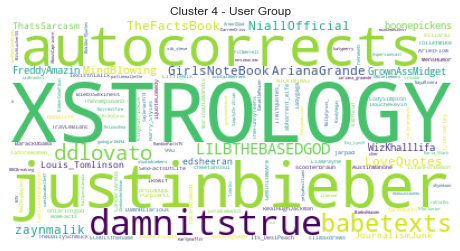

{'justinbieber': 6.61, 'XSTROLOGY': 4.82, 'ArianaGrande': 2.82, 'babetexts': 2.49, 'ddlovato': 2.27, 'autocorrects': 2.2, 'LILBTHEBASEDGOD': 2.19, 'NiallOfficial': 2.1, 'damnitstrue': 2.09, 'LoveQuotes': 1.88, 'selenagomez': 1.85, 'davidguetta': 1.82, 'zaynmalik': 1.53, 'ThatsSarcasm': 1.53, 'TheFactsBook': 1.5, 'WizKhalllifa': 1.3, 'NICKIMINAJ': 1.29, 'Louis_Tomlinson': 1.29, 'ladygaga': 1.26, 'GirlsNoteBook': 1.23, 'DamnHiIarious': 1.21, 'FreddyAmazin': 1.2, 'MindBlowing': 1.15, 'LiamPayne': 1.11, 'scooterbraun': 1.1, 'BiebsHeaven': 1.07, 'TravLeBlanc': 1.05, 'DailyLoud': 0.96, '99u': 0.94, 'RAtheRuggedMan': 0.91, 'CodySimpson': 0.87, 'dadalife': 0.86, 'ECHOisthename': 0.79, 'LittleMix': 0.77, 'TheFunnyTeens': 0.76, 'JaiBrooks1': 0.73, 'tyleroakley': 0.72, 'greysonchance': 0.7, 'shynexoo': 0.68, 'Maria_Stack': 0.67, 'GirlsGeneration': 0.66, 'Complex': 0.65, 'lucyhale': 0.64, 'OneWonderWoman': 0.63, 'DarrenCriss': 0.63, 'AustinMahone': 0.62, 'JaredLeto': 0.6, 'JamesBourne': 0.59, 'WoW

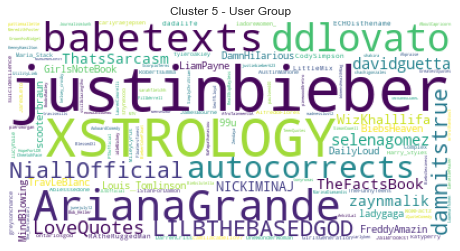

the number of clusters: 6
Cluster 0, with the numbers = 103
Cluster 1, with the numbers = 1766
Cluster 2, with the numbers = 348
Cluster 3, with the numbers = 148
Cluster 4, with the numbers = 99
Cluster 5, with the numbers = 163
KMeans: Avg: 0.0421  K: 6 time(sec): 0.31914639472961426


In [69]:
## min_df = If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# max_ft = When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
K = 6
n_feats = 15
kmeans, timeEx = Cal_KMeans(matrix, K)

labels = kmeans.labels_
n_clusters_ = len(set(labels)) 

silhouette_avg = silhouetteEval(X, labels)
#silhouettePlot(X, K, labels, silhouette_avg, "Kmeans")

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)        
visualizer.show()  



plotClusterFeatures2(df, labels, n_feats)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = matrix.columns) 
generateWordCloudsKMeans(centroids, col)

print("the number of clusters:", n_clusters_)
num_clusters(X, labels)
output("KMeans", silhouette_avg, K, timeEx)

In [67]:
K = 233
kmeans, timeEx = Cal_KMeans(matrix, K)
labels = kmeans.labels_
n_clusters_ = len(set(labels)) 
silhouette_avg = silhouetteEval(X, labels)
print("the number of clusters:", n_clusters_)
num_clusters(X, labels)
output("KMeans", silhouette_avg, K, timeEx)

the number of clusters: 233
Cluster 0, with the numbers = 1
Cluster 1, with the numbers = 1
Cluster 2, with the numbers = 285
Cluster 3, with the numbers = 9
Cluster 4, with the numbers = 19
Cluster 5, with the numbers = 20
Cluster 6, with the numbers = 10
Cluster 7, with the numbers = 21
Cluster 8, with the numbers = 20
Cluster 9, with the numbers = 14
Cluster 10, with the numbers = 46
Cluster 11, with the numbers = 1
Cluster 12, with the numbers = 11
Cluster 13, with the numbers = 13
Cluster 14, with the numbers = 22
Cluster 15, with the numbers = 14
Cluster 16, with the numbers = 11
Cluster 17, with the numbers = 12
Cluster 18, with the numbers = 5
Cluster 19, with the numbers = 1
Cluster 20, with the numbers = 2
Cluster 21, with the numbers = 10
Cluster 22, with the numbers = 13
Cluster 23, with the numbers = 15
Cluster 24, with the numbers = 24
Cluster 25, with the numbers = 23
Cluster 26, with the numbers = 16
Cluster 27, with the numbers = 6
Cluster 28, with the numbers = 11
Clu

In [68]:
K = 7
kmeans, timeEx = Cal_KMeans(matrix, K)
labels = kmeans.labels_
n_clusters_ = len(set(labels)) 
silhouette_avg = silhouetteEval(X, labels)
print("the number of clusters:", n_clusters_)
num_clusters(X, labels)
output("KMeans", silhouette_avg, K, timeEx)

the number of clusters: 7
Cluster 0, with the numbers = 102
Cluster 1, with the numbers = 1626
Cluster 2, with the numbers = 332
Cluster 3, with the numbers = 147
Cluster 4, with the numbers = 99
Cluster 5, with the numbers = 157
Cluster 6, with the numbers = 164
KMeans: Avg: 0.0434  K: 7 time(sec): 0.3334696292877197


In [61]:
def Cal_DBSCAN_Test(X, eps, min_samples):
   for x in eps: 
        for y in min_samples:
           db = DBSCAN(eps = x, min_samples = y, metric = 'euclidean', n_jobs = -1).fit(X)
           labels = db.labels_
           if len(set(labels)) >= 2 and len(set(labels)) <= num_samples - 1:
               print("labels", labels)
               silhouette_avg = round(silhouette_score(X, labels), 4) 
               print("eps = {}, min_samples = {}, SilhouetteEval = {}\n".format(x, y, silhouette_avg))
   print("Finish")
eps = [x/10 for x in range(1, 11)]
min_samples = [x for x in range(2, 6)]
db = Cal_DBSCAN_Test(matrix, eps, min_samples)

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.1, min_samples = 2, SilhouetteEval = -0.0291

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.1, min_samples = 3, SilhouetteEval = -0.1036

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.1, min_samples = 4, SilhouetteEval = -0.1375

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.1, min_samples = 5, SilhouetteEval = -0.154

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.2, min_samples = 2, SilhouetteEval = -0.0285

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.2, min_samples = 3, SilhouetteEval = -0.1023

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.2, min_samples = 4, SilhouetteEval = -0.1375

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.2, min_samples = 5, SilhouetteEval = -0.154

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.3, min_samples = 2, SilhouetteEval = -0.0261

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.3, min_samples = 3, SilhouetteEval = -0.101

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.3, min_samples = 4, SilhouetteEval = -0.1345

labels [-1 -1 -1 ... -1 -1  1]
eps = 0.3, min_samples = 5, Silhouett

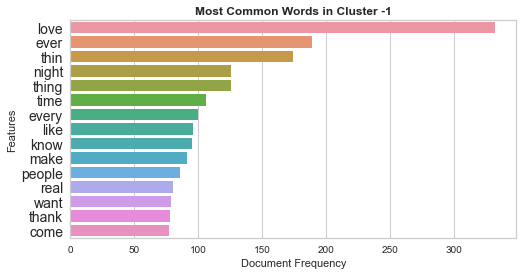

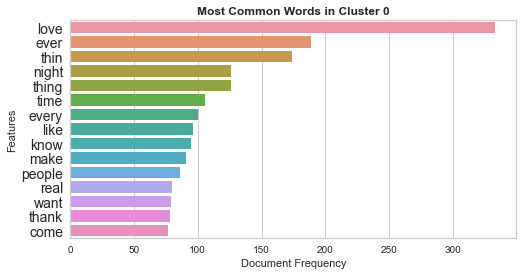

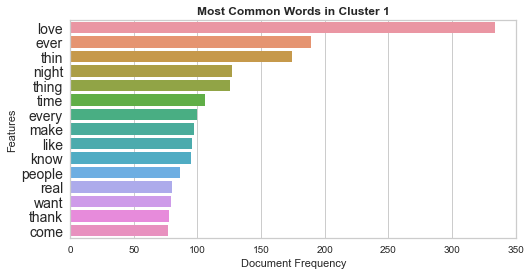

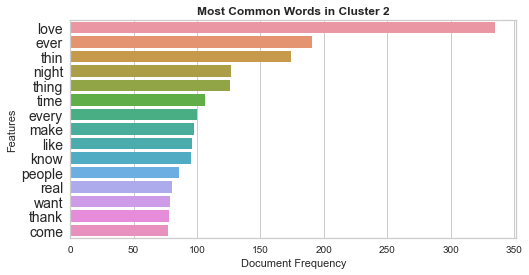

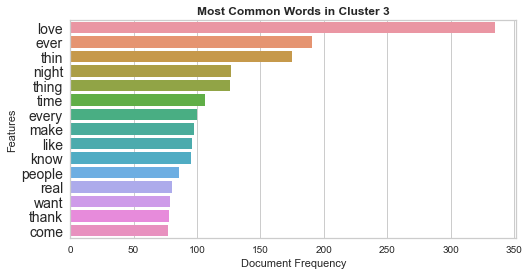

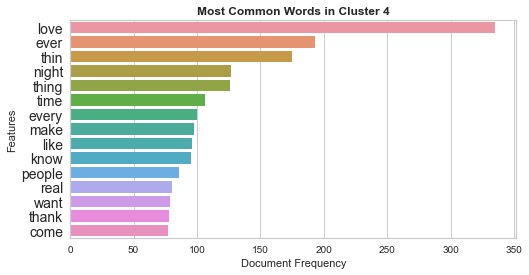

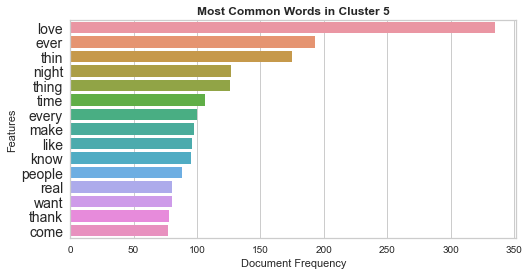

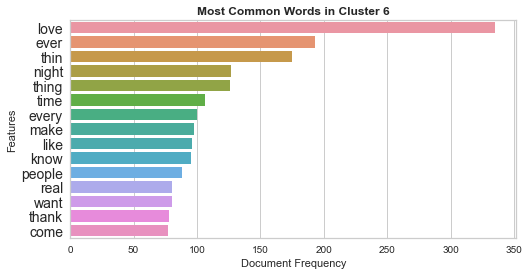

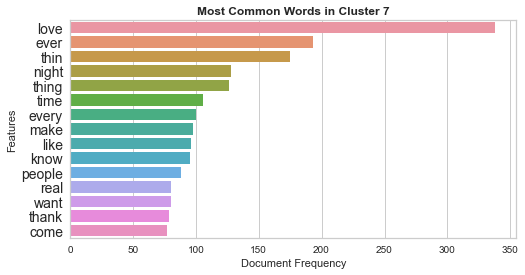

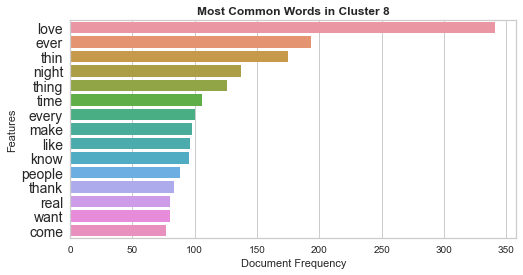

{'XSTROLOGY': 11.19, 'justinbieber': 10.18, 'damnitstrue': 5.33, 'LILBTHEBASEDGOD': 5.32, 'NiallOfficial': 5.05, 'zaynmalik': 4.88, 'babetexts': 4.79, 'ArianaGrande': 4.79, 'ddlovato': 4.24, 'LoveQuotes': 3.97, 'Louis_Tomlinson': 2.94, 'LiamPayne': 2.65, 'FreddyAmazin': 2.65, 'Harry_Styles': 2.46, 'pattiemallette': 2.44, 'NICKIMINAJ': 2.44, 'WizKhalllifa': 2.38, 'JaiBrooks1': 2.18, 'iStanForDamon': 2.12, 'NiaLong': 1.97, 'JackAllTimeLow': 1.93, 'KennyHamilton': 1.91, 'NayaRivera': 1.91, 'RobertsEmma': 1.85, 'JaredLeto': 1.85, 'autocorrects': 1.85, 'MaPapathanasiou': 1.67, 'greysonchance': 1.61, 'GirlsNoteBook': 1.59, 'SimplyChri5tian': 1.59, 'GeminisWeAre': 1.35, 'TheFactsBook': 1.33, 'ladygaga': 1.32, 'MileyCyrus': 1.32, 'TheFunnyTeens': 1.32, 'CodySimpson': 1.32, 'JosephMorgan': 1.12, 'WoWFactz': 1.08, 'MindBlowing': 1.08, 'BiebsSexiness': 1.06, 'scooterbraun': 1.06, 'ECHOisthename': 1.06, 'selenagomez': 1.06, 'druidDUDE': 1.06, 'BWaldorfQuotes': 1.06, 'stillblazingtho': 1.06, 'Littl

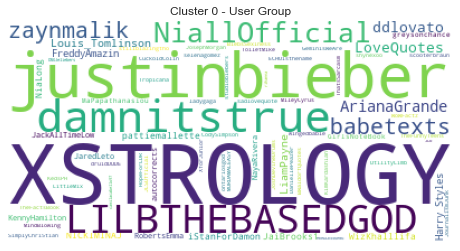

{'autocorrects': 5.0, 'babetexts': 4.0, 'ArianaGrande': 4.0, 'XSTROLOGY': 3.0, '99u': 3.0, 'selenagomez': 3.0, 'justinbieber': 3.0, 'LoveQuotes': 3.0, 'LILBTHEBASEDGOD': 3.0, 'BiebsHeaven': 2.0, 'tyleroakley': 2.0, 'zaynmalik': 2.0, 'RAtheRuggedMan': 2.0, 'TravLeBlanc': 2.0, 'DamnHiIarious': 2.0, 'OneWonderWoman': 2.0, 'damnitstrue': 2.0, 'Dion_Live': 1.0, 'NiallOfficial': 1.0, 'ontariosgod': 1.0, 'tonyromas': 1.0, 'GeoffLloyd': 1.0, 'ladygaga': 1.0, 'NotTinaFey': 1.0, 'Zendaya': 1.0, 'LiamPayne': 1.0, 'HopeForLDR': 1.0, 'iadorewomen_': 1.0, 'travismills': 1.0, 'sarahfletchh': 1.0, 'UtilityLimb': 1.0, 'carlyken': 1.0, 'suicidesilence': 1.0, 'AwkwardComedy': 1.0, 'GrownAssMidget': 1.0, 'ddlovato': 1.0, 'ECHOisthename': 1.0, 'Maria_Stack': 1.0, 'Biebslutella': 1.0, 'carlyraejepsen': 1.0, 'WomensHealthMag': 1.0, 'The_MartiniGirl': 1.0, 'TeenQuotes': 1.0, 'GirlsNoteBook': 1.0, 'IANMHARDING': 1.0, 'Lowenaffchen': 1.0, 'BoobsRadley': 1.0, 'Bob_Heller': 1.0, 'MSkroban': 1.0, 'idyllicdrew': 1.

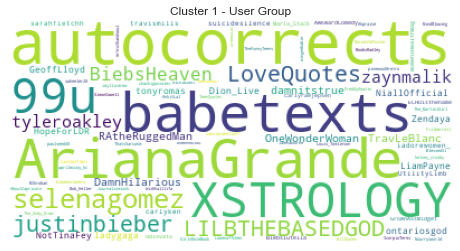

{}
{'NotTildaSwinton': 2.44, 'OhWonka': 2.01, 'autocorrects': 1.49, 'rohtalks': 0.84, 'angelina_mxoxo': 0.84, 'ladygaga': 0.84, 'MTV': 0.84, 'chuchugoogoo': 0.84, 'TulisanPELAJAR': 0.84, 'JaiBrooks1': 0.84, 'abhorrent_wife': 0.84, 'NiallOfficial': 0.64, 'babetexts': 0.64, 'jarpad': 0.64, 'NICKIMINAJ': 0.64, 'StrongerUnited1': 0.64, 'cher': 0.43, 'XSTROLOGY': 0.43, 'dadalife': 0.43, 'iQuoteComedy': 0.43, 'ThatsSarcasm': 0.43, 'lowkeybrent': 0.43, 'CoryMonteith': 0.43, 'OMGJeliebers': 0.43, 'TheFunnyTeens': 0.43, 'MitchLuckerSS': 0.32, 'Boleyngirly': 0.32, 'mohituraina': 0.32, 'madnesslust2': 0.32, 'BiebsSexiness': 0.32, 'iadorewomen_': 0.32, 'frankieboyle': 0.32, '99u': 0.32, 'taylorswift13': 0.32, 'JulesJordan': 0.32, 'AustinMahone': 0.32, 'comedyfish': 0.32, 'studiobiebers': 0.32, 'DalaiLama': 0.32, '411Music': 0.32, 'katyperry': 0.32, 'GreatestQuotes': 0.32, 'The_MartiniGirl': 0.32, 'GirlsNoteBook': 0.32, 'MDMOLINARI': 0.32, 'MileyCyrus': 0.32, 'ElizabethTaylor': 0.32, 'justinbieber'

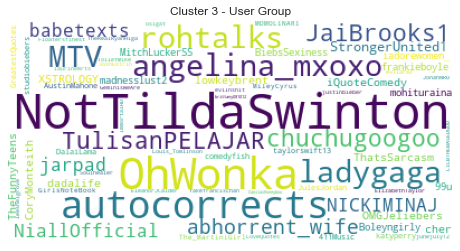

{'babetexts': 3.0, 'KennyHamilton': 2.0, 'damnitstrue': 2.0, 'laughposts': 1.0, 'XSTROLOGY': 1.0, 'GrownAssMidget': 1.0, 'TheFactsBook': 1.0, 'justinbieber': 1.0, 'Bob_Heller': 1.0, 'IamK_KMaudal': 1.0, 'UliSoMobby': 1.0, 'WizKhalllifa': 1.0, 'SufjanQuoter': 1.0, 'MindBlowing': 1.0, 'youlovedesha': 1.0, 'tat2skatermom': 1.0, 'SimplyChri5tian': 1.0, 'AllyBallyBeal': 1.0}


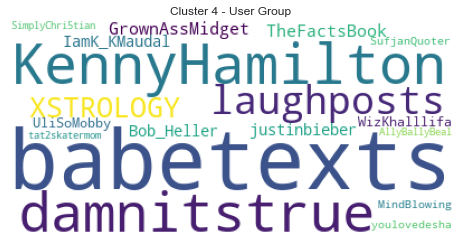

{'GirlsNoteBook': 6.79, 'autocorrects': 6.78, 'XSTROLOGY': 4.1, 'damnitstrue': 4.1, 'babetexts': 3.33, 'TheFactsBook': 2.69, 'MindBlowing': 2.69, 'LILBTHEBASEDGOD': 2.56, 'iadorewomen_': 2.18, 'WizKhalllifa': 2.18, 'LoveQuotes': 2.18, 'edsheeran': 2.05, 'ddlovato': 1.92, 'boonepickens': 1.92, 'justinbieber': 1.92, 'DamnHiIarious': 1.54, 'AnkitLal': 1.54, 'KEVINGETEM': 1.41, 'scooterbraun': 1.41, 'SexFactsOfLife': 1.41, 'iQuoteComedy': 1.41, 'ThatsSarcasm': 1.41, 'iTwitQuotes_': 1.41, 'CamilasHoneyboo': 1.41, 'GrownAssMidget': 1.28, 'TheDailySchmuck': 1.28, 'JournalismJunk': 1.28, 'iexistniallx': 1.28, 'Its_DesiPeach': 1.28, 'Mytwoscentz': 0.77, 'TheShortyB': 0.77, 'XforJunior': 0.77, 'Drake': 0.77, 'xib_steve': 0.77, 'babenessness': 0.77, 'DarrenCriss': 0.77, 'TheFunnyTeens': 0.77, 'ElgatoEsmio': 0.77, 'brittany081012': 0.77, 'rohtalks': 0.64, 'ontariosgod': 0.64, 'k': 0.64, 'Aspersioncast': 0.64, 'tyleroakley': 0.64, 'forrrestfire': 0.64, 'henweb': 0.64, 'BiebsSexiness': 0.64, 'dadali

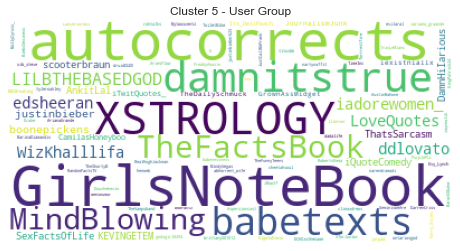

{'justinbieber': 5.56, 'CodySimpson': 3.39, 'ddlovato': 2.25, 'NiallOfficial': 2.16, 'DamnHiIarious': 1.79, 'FreddyAmazin': 1.77, 'autocorrects': 1.75, 'NICKIMINAJ': 1.75, 'RealSkipBayless': 1.7, 'zaynmalik': 1.66, 'Complex': 1.23, 'SheeeRatchet': 1.23, 'iQuoteComedy': 1.2, 'scooterbraun': 1.18, 'LittleMix': 1.14, 'TheFunnyTeens': 1.14, 'MeredithFoster': 1.14, 'Louis_Tomlinson': 1.14, 'babetexts': 1.11, 'MileyCyrus': 1.05, 'Tropicana': 1.05, 'iBiebsGasm': 0.62, 'StephenAtHome': 0.62, 'travismills': 0.62, 'detroit_et': 0.62, 'GirlsNoteBook': 0.62, 'youlovedesha': 0.62, 'CokerHannah': 0.62, 'RickyPDillon': 0.62, 'HEADLESSGANG': 0.62, 'Brittanysnow': 0.62, 'Akpraise': 0.62, 'Couch_Of_Truth': 0.62, 'cher': 0.59, 'LexOnLuxe': 0.59, 'rameshnswamy': 0.59, 'DalaiLama': 0.59, 'Eminem': 0.59, 'selenagomez': 0.59, '_kisho': 0.59, 'RobsTwitte': 0.59, 'SexFactsOfLife': 0.59, 'iStanForDamon': 0.59, 'Satoria_Bell': 0.59, 'lucyhale': 0.59, 'jarpad': 0.59, 'JournalismJunk': 0.59, 'ThatsSarcasm': 0.59, 

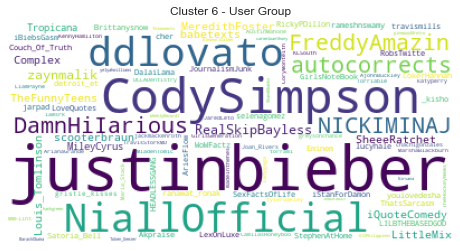

{'NiallOfficial': 3.71, 'justinbieber': 3.71, 'ddlovato': 1.39, 'Louis_Tomlinson': 1.39, 'NathanSykes': 1.39, 'Complex': 1.16, 'taylorswift13': 1.16, 'babetexts': 1.16, 'TomFletcher': 1.16, 'RickyPDillon': 1.16, 'ninadobrev': 1.16, 'Brittanysnow': 1.16, 'MitchLuckerSS': 0.82, 'godsgirl8494': 0.82, 'rubydoomsday': 0.82, 'idyllicdrew': 0.82, 'BieberCokeFloat': 0.82, 'DaniellePeazer': 0.58, 'JoshDevineDrums': 0.58, 'BiebsHeaven': 0.58, 'Bieberscupcake1': 0.58, 'aew9': 0.58, 'john_loydall': 0.58, 'cheetahsoul': 0.58, 'travismills': 0.58, 'JulesJordan': 0.58, 'Harry_Styles': 0.58, 'sarahfletchh': 0.58, 'NormaniKordei': 0.58, 'katyperry': 0.58, 'MTV': 0.58, 'TheFactsBook': 0.58, 'SexFactsOfLife': 0.58, 'LoganLerman': 0.58, 'xtina': 0.58, 'RealHughJackman': 0.58, 'torrami': 0.58, 'mrtruthandsoul': 0.58, 'Juan_Golbezze': 0.58, 'LaurenCimorelli': 0.58, 'LucasMoraisR': 0.58, 'HCHeadlines': 0.58, 'ArianaGrande': 0.58, 'WoWFactz': 0.58, 'NICKIMINAJ': 0.58, 'swheeler28': 0.58, 'nPhelendriqal': 0.58

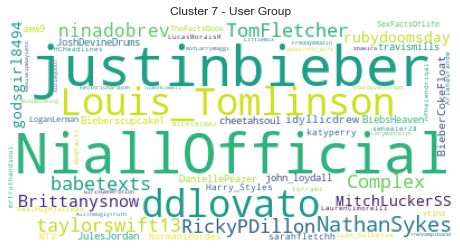

{'justinbieber': 6.75, 'NiallOfficial': 5.6, 'TeamFollowWacky': 3.58, 'Complex': 2.77, 'taylorswift13': 2.77, 'Louis_Tomlinson': 2.72, 'Brittanysnow': 2.32, 'ArianaGrande': 2.26, 'NICKIMINAJ': 2.19, 'iexistniallx': 1.83, 'FckingMermaid_': 1.83, 'gofollow8': 1.83, 'RickyPDillon': 1.78, 'OMGJeliebers': 1.75, 'DaniellePeazer': 1.73, 'babetexts': 1.71, 'TomFletcher': 1.71, 'ninadobrev': 1.71, 'aew9': 1.65, 'Harry_Styles': 1.65, 'ddlovato': 1.65, 'katyperry': 1.65, 'TheFactsBook': 1.65, 'RealHughJackman': 1.65, 'LaurenCimorelli': 1.65, 'LittleMix': 1.65, 'shierology': 1.22, 'AmmoRaju': 1.22, 'laurinemrts': 1.22, 'harriy_styIess': 1.22, 'marveloustylxs': 1.22, 'FreddyAmazin': 1.2, 'LiamPayne': 1.14, 'selenagomez': 1.14, 'JoshDevineDrums': 1.12, 'john_loydall': 1.12, 'travismills': 1.12, 'sarahfletchh': 1.12, 'NormaniKordei': 1.12, 'MTV': 1.12, 'xtina': 1.12, 'torrami': 1.12, 'mrtruthandsoul': 1.12, 'Juan_Golbezze': 1.12, 'HCHeadlines': 1.12, 'WoWFactz': 1.12, 'swheeler28': 1.12, 'suzieQ0007'

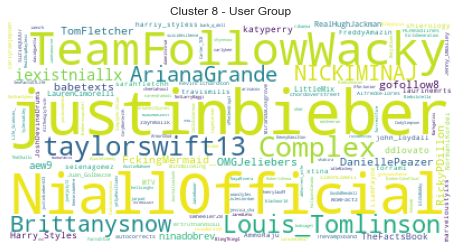

{'XSTROLOGY': 34.0, 'justinbieber': 32.0, 'NiallOfficial': 17.0, 'babetexts': 16.0, 'LILBTHEBASEDGOD': 16.0, 'LoveQuotes': 15.0, 'ddlovato': 14.0, 'zaynmalik': 12.0, 'ArianaGrande': 12.0, 'damnitstrue': 12.0, 'LiamPayne': 10.0, 'WizKhalllifa': 9.0, 'iStanForDamon': 8.0, 'FreddyAmazin': 8.0, 'RobertsEmma': 7.0, 'JaredLeto': 7.0, 'autocorrects': 7.0, 'Louis_Tomlinson': 7.0, 'GirlsNoteBook': 6.0, 'SimplyChri5tian': 6.0, 'ladygaga': 5.0, 'pattiemallette': 5.0, 'MileyCyrus': 5.0, 'NICKIMINAJ': 5.0, 'TheFunnyTeens': 5.0, 'CodySimpson': 5.0, 'greysonchance': 4.0, 'BiebsSexiness': 4.0, 'ECHOisthename': 4.0, 'selenagomez': 4.0, 'BWaldorfQuotes': 4.0, 'LittleMix': 4.0, 'JaiBrooks1': 4.0, 'DaniellePeazer': 3.0, 'ontariosgod': 3.0, 'MURDAMALEASY': 3.0, 'JoshDevineDrums': 3.0, 'KennyHamilton': 3.0, 'Harry_Styles': 3.0, 'JLSOfficial': 3.0, 'studiobiebers': 3.0, 'KimKardashian': 3.0, 'TheFactsBook': 3.0, 'ThatsSarcasm': 3.0, 'GeminisWeAre': 3.0, 'OMGJeliebers': 3.0, 'camilacabello97': 3.0, 'NayaRiver

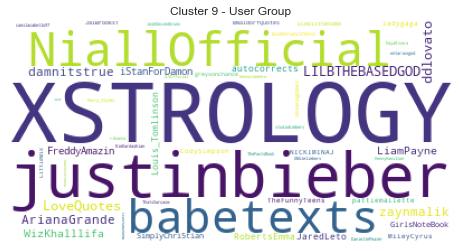

DBSCAN labels [ -1  -1  -1 ... 226  -1   2]
noise points: 1585
core samples index [   3    8   10 ... 2621 2624 2626]
the number of clusters: 233
Cluster 0, with the numbers = 2
Cluster 1, with the numbers = 6
Cluster 2, with the numbers = 184
Cluster 3, with the numbers = 4
Cluster 4, with the numbers = 4
Cluster 5, with the numbers = 6
Cluster 6, with the numbers = 2
Cluster 7, with the numbers = 5
Cluster 8, with the numbers = 10
Cluster 9, with the numbers = 67
Cluster 10, with the numbers = 5
Cluster 11, with the numbers = 5
Cluster 12, with the numbers = 3
Cluster 13, with the numbers = 3
Cluster 14, with the numbers = 2
Cluster 15, with the numbers = 4
Cluster 16, with the numbers = 7
Cluster 17, with the numbers = 3
Cluster 18, with the numbers = 4
Cluster 19, with the numbers = 2
Cluster 20, with the numbers = 7
Cluster 21, with the numbers = 5
Cluster 22, with the numbers = 3
Cluster 23, with the numbers = 4
Cluster 24, with the numbers = 22
Cluster 25, with the numbers = 4
C

In [62]:
db, timeEx = Cal_DBSCAN(matrix, 0.7, 2)
 
labels      = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_    = list(labels).count(-1)
   
silhouette_avg = silhouetteEval(X, labels)
#silhouettePlot(X, n_clusters_, labels, silhouette_avg, "DBSCAN")
plotClusterFeatures3(df, labels, n_feats)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(labels)
#if -1 in unique_labels:
#    unique_labels.remove(-1)

pp = 0
for k in unique_labels:
    # 选出每一个cluster的核心点
    # 找到CLUSTER有几个USER的TWEET + 判断是否是核心点
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    centroids = pd.DataFrame(xy, columns = matrix.columns) 
    generateWordCloudsDBSCAN(centroids, col, k)
    if pp == 9:
        break
    else:
        pp += 1
    
print("DBSCAN labels", labels)
print("noise points:", n_noise_)
print("core samples index", db.core_sample_indices_)

print("the number of clusters:", n_clusters_)
num_clusters(X, labels)
output("DBSCAN", silhouette_avg, n_clusters_, timeEx)

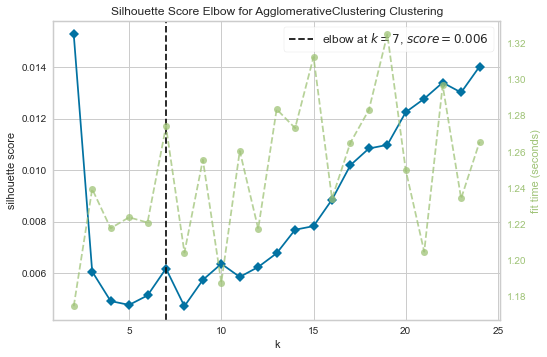

In [63]:
max_k = 25
agglomerative = AgglomerativeClustering(affinity = "euclidean")
visualizer = KElbowVisualizer(agglomerative, metric='silhouette', k=(2, max_k), timings=True, locate_elbow=True)
K = visualizer.fit(matrix).elbow_value_
visualizer.show()

In [65]:
def plot_dendrogram(X, labels):
    Z = hi.linkage(X, 'ward')
    fig, axes = plt.subplots(figsize=(30, 20)) # Weight * Height
    dn = hi.dendrogram(Z, ax=axes, labels = labels, leaf_rotation=90) #orientation='right' , leaf_rotation=90
    plt.title('Hierarchical Clustering Dendrogram', fontsize = 24)
    plt.yticks(fontsize = 20)
    plt.ylabel("Tree Depth", fontsize = 24)
    plt.xlabel("Number for Cluster & User Name", fontsize = 24)
    plt.xticks(fontsize = 20)
    plt.grid(False)
    plt.show()
    return dn

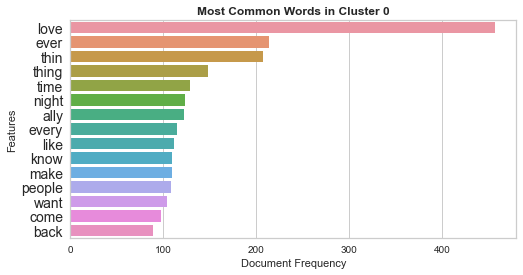

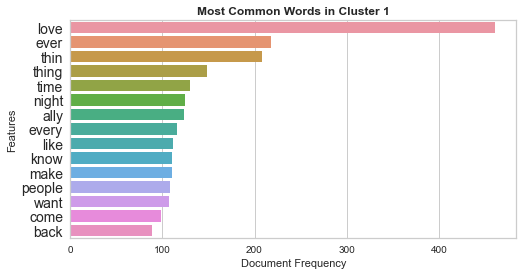

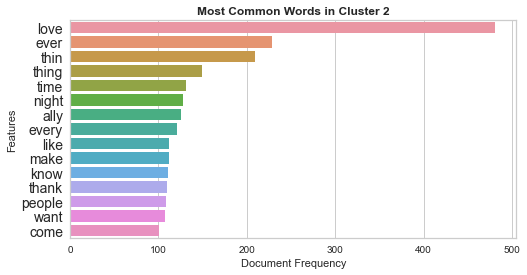

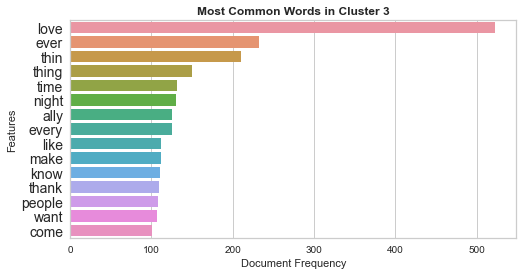

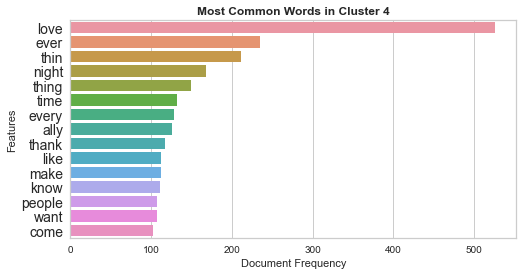

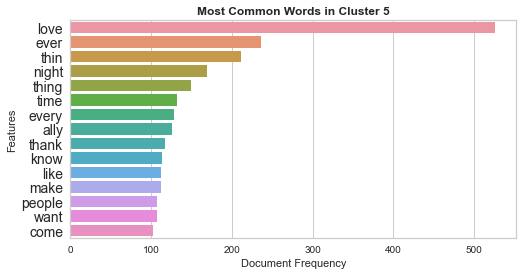

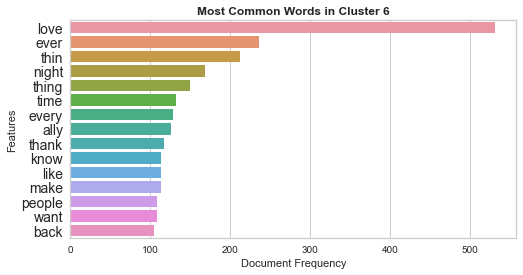

{}
{'justinbieber': 7.5, 'Louis_Tomlinson': 4.86, 'ddlovato': 3.79, 'CodySimpson': 2.66, 'NiallOfficial': 2.65, 'XSTROLOGY': 2.1, 'AustinMahone': 2.06, 'NICKIMINAJ': 1.75, 'LiamPayne': 1.74, 'MTV': 1.74, 'Complex': 1.42, 'LittleMix': 1.39, 'AlfredoFlores': 1.37, 'RealHughJackman': 1.37, 'scooterbraun': 1.35, 'GirlsGeneration': 1.35, 'RAtheRuggedMan': 1.11, 'DamnHiIarious': 1.09, 'GirlsNoteBook': 1.08, 'autocorrects': 1.06, 'MitchLuckerSS': 1.05, 'ThatsSarcasm': 1.04, 'LOREEN_TALHAOUI': 1.03, 'TheFactsBook': 1.03, 'DailyLoud': 1.03, 'justinbieber623': 1.03, 'JoshDevineDrums': 1.02, 'CoryMonteith': 1.02, 'tyleroakley': 1.01, 'RealSkipBayless': 1.01, 'jackmackenroth': 1.0, 'pinewood8retro': 1.0, 'MileyCyrus': 0.99, 'zaynmalik': 0.98, 'AnkitLal': 0.8, 'Evy_Lynch': 0.78, 'abhorrent_wife': 0.77, 'lucyhale': 0.75, 'SheeeRatchet': 0.74, 'GrownAssMidget': 0.73, 'jdbfriend4ever': 0.73, 'SMTOWNGLOBAL': 0.73, 'iamsrk': 0.72, 'greysonchance': 0.71, 'katyperry': 0.71, 'JaredLeto': 0.71, 'cesc4offici

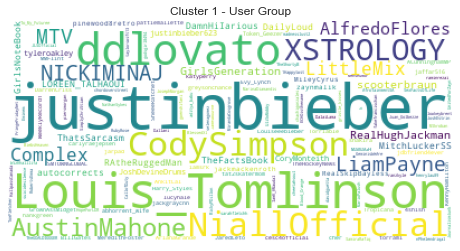

{'ddlovato': 2.0, 'justinbieber': 2.0, 'GeorgioAvanti': 1.0, 'middleclassprob': 1.0, 'SneadsFerry': 1.0, 'ladygaga': 1.0, 'Zendaya': 1.0, 'Internews': 1.0, 'taylorswift13': 1.0, '2chainz': 1.0, 'AustinMahone': 1.0, '411Music': 1.0, 'sweet_toof': 1.0, 'MTV': 1.0, 'GwynethPaltrow': 1.0, 'TomFletcher': 1.0, 'TeamFollowWacky': 1.0, 'LarusheSounds': 1.0, 'JournalismJunk': 1.0, 'AriesFlow': 1.0, 'PTXofficial': 1.0, 'LittleMix': 1.0, 'Visualsnap': 1.0, 'FillWerrell': 1.0, 'blaize323': 1.0, 'E_Sunglasses': 1.0, 'JoshEstrin': 1.0, 'ShaneEbanks': 1.0, 'SheeeRatchet': 1.0, 'CodySimpson': 1.0, 'SMTOWNGLOBAL': 1.0, 'NathanSykes': 1.0, 'josafaroliveira': 1.0}


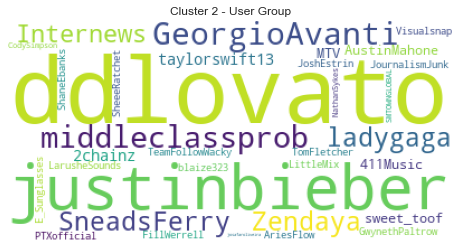

{'XSTROLOGY': 34.0, 'justinbieber': 32.0, 'NiallOfficial': 17.0, 'babetexts': 16.0, 'LILBTHEBASEDGOD': 16.0, 'LoveQuotes': 15.0, 'ddlovato': 14.0, 'zaynmalik': 12.0, 'ArianaGrande': 12.0, 'damnitstrue': 12.0, 'LiamPayne': 10.0, 'WizKhalllifa': 9.0, 'iStanForDamon': 8.0, 'FreddyAmazin': 8.0, 'RobertsEmma': 7.0, 'JaredLeto': 7.0, 'autocorrects': 7.0, 'Louis_Tomlinson': 7.0, 'GirlsNoteBook': 6.0, 'SimplyChri5tian': 6.0, 'ladygaga': 5.0, 'pattiemallette': 5.0, 'MileyCyrus': 5.0, 'NICKIMINAJ': 5.0, 'TheFunnyTeens': 5.0, 'CodySimpson': 5.0, 'greysonchance': 4.0, 'BiebsSexiness': 4.0, 'ECHOisthename': 4.0, 'selenagomez': 4.0, 'BWaldorfQuotes': 4.0, 'LittleMix': 4.0, 'JaiBrooks1': 4.0, 'DaniellePeazer': 3.0, 'ontariosgod': 3.0, 'MURDAMALEASY': 3.0, 'JoshDevineDrums': 3.0, 'KennyHamilton': 3.0, 'Harry_Styles': 3.0, 'JLSOfficial': 3.0, 'studiobiebers': 3.0, 'KimKardashian': 3.0, 'TheFactsBook': 3.0, 'ThatsSarcasm': 3.0, 'GeminisWeAre': 3.0, 'OMGJeliebers': 3.0, 'camilacabello97': 3.0, 'NayaRiver

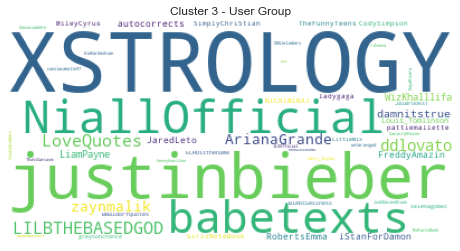

{'NiallOfficial': 2.02, 'babetexts': 2.02, 'autocorrects': 2.02, 'leesnelgrove': 1.4, 'jarpad': 1.24, 'NICKIMINAJ': 1.24, 'StrongerUnited1': 1.24, 'Complex': 0.79, 'XSTROLOGY': 0.79, 'Markgatiss': 0.79, 'selenagomez': 0.79, 'TheFactsBook': 0.79, 'JaredLeto': 0.79, 'TomFletcher': 0.79, 'MindBlowing': 0.79, 'chordoverstreet': 0.79, 'shynexoo': 0.79, 'ManSquared973': 0.79, 'MitchLuckerSS': 0.62, 'Boleyngirly': 0.62, 'mohituraina': 0.62, 'madnesslust2': 0.62, 'BiebsSexiness': 0.62, 'iadorewomen_': 0.62, 'frankieboyle': 0.62, '99u': 0.62, 'taylorswift13': 0.62, 'JulesJordan': 0.62, 'AustinMahone': 0.62, 'comedyfish': 0.62, 'studiobiebers': 0.62, 'DalaiLama': 0.62, '411Music': 0.62, 'katyperry': 0.62, 'GreatestQuotes': 0.62, 'The_MartiniGirl': 0.62, 'GirlsNoteBook': 0.62, 'MDMOLINARI': 0.62, 'MileyCyrus': 0.62, 'ElizabethTaylor': 0.62, 'justinbieber': 0.62, 'fakefrancischan': 0.62, 'laurinemrts': 0.62, 'Floatersfinest': 0.62, 'osigat': 0.62, 'evilaral': 0.62, 'LoveQuotes': 0.62, 'LILBTHEBASE

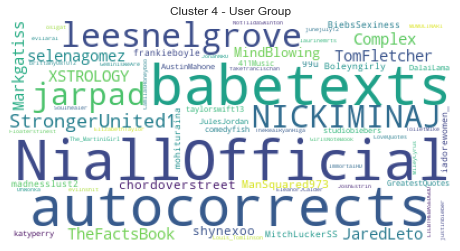

{'justinbieber': 6.33, 'ddlovato': 4.91, 'LittleMix': 2.89, 'CodySimpson': 2.76, 'selenagomez': 2.21, 'NiallOfficial': 2.15, 'scooterbraun': 2.15, 'Louis_Tomlinson': 2.15, 'autocorrects': 2.09, 'DamnHiIarious': 2.03, 'ladygaga': 1.47, 'AustinMahone': 1.47, 'lucyhale': 1.47, 'yelyahwilliams': 1.47, 'PinchSuckBlow': 1.47, 'XSTROLOGY': 1.41, 'RealHughJackman': 1.41, 'ArianaGrande': 1.41, 'SMTOWNGLOBAL': 1.41, 'zaynmalik': 1.35, 'AmmoRaju': 1.35, 'BtooCold501': 1.35, 'BieberCokeFloat': 1.35, 'LoveQuotes': 1.35, 'DerekMaak': 1.35, 'shynexoo': 1.35, 'BiebsHeaven': 0.74, 'Complex': 0.74, 'angelina_mxoxo': 0.74, 'henrylau89': 0.74, 'Aspersioncast': 0.74, 'barb_q_dell': 0.74, 'travismills': 0.74, 'taylorswift13': 0.74, 'JackAllTimeLow': 0.74, 'pattiemallette': 0.74, 'katyperry': 0.74, 'TheLexiLove': 0.74, 'louteasdale': 0.74, 'carlyraejepsen': 0.74, 'IANMHARDING': 0.74, 'MileyCyrus': 0.74, 'iQuoteComedy': 0.74, 'aimeeorsomethng': 0.74, 'fakefrancischan': 0.74, 'ZacEfron': 0.74, 'kelsey_crosby':

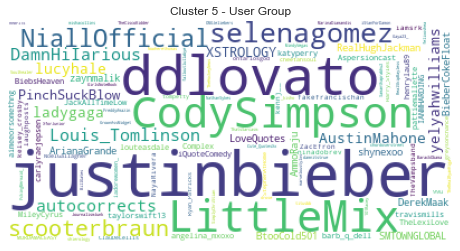

{'TeamFollowWacky': 4.3, 'gofollow8': 3.3, 'iexistniallx': 2.58, 'FckingMermaid_': 2.58, 'shierology': 1.72, 'AmmoRaju': 1.72, 'laurinemrts': 1.72, 'harriy_styIess': 1.72, 'marveloustylxs': 1.72, 'OMGJeliebers': 1.72, 'justinbieber': 1.58, 'iQuoteComedy': 1.22, 'ArianaGrande': 1.22, 'iamsrk': 0.86, 'DaniellePeazer': 0.86, 'MURDAMALEASY': 0.86, 'TheChalls': 0.86, 'henrylau89': 0.86, 'greysonchance': 0.86, 'LiamPayne': 0.86, 'henweb': 0.86, 'barb_q_dell': 0.86, 'KennyHamilton': 0.86, 'jessica_cha': 0.86, '99u': 0.86, 'narendramodi': 0.86, 'suicidesilence': 0.86, 'AustinMahone': 0.86, 'Life_Sciences_': 0.86, 'blackworld': 0.86, 'GreatestQuotes': 0.86, 'selenagomez': 0.86, 'Biebslutella': 0.86, 'HallpassCanada': 0.86, 'idleMickey': 0.86, 'BieberCokeFloat': 0.86, 'jarpad': 0.86, 'JournalismJunk': 0.86, 'russwest44': 0.86, 'hellsinghx': 0.86, 'Lorainele047': 0.86, 'FactsOrDie': 0.86, 'wowstyIes': 0.86, 'BlingThing4': 0.86, 'FreddyAmazin': 0.86, 'RickyPDillon': 0.86, 'justinbieber623': 0.86, 

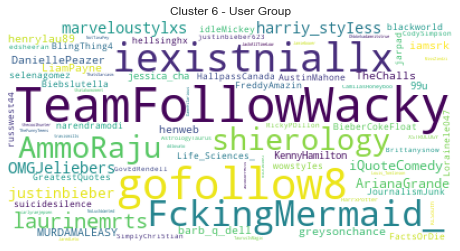

agglomerative labels [0 0 0 ... 0 0 0]
the number of clusters: 7
Cluster 0, with the numbers = 2417
Cluster 1, with the numbers = 38
Cluster 2, with the numbers = 51
Cluster 3, with the numbers = 42
Cluster 4, with the numbers = 40
Cluster 5, with the numbers = 18
Cluster 6, with the numbers = 21
AgglomerativeClustering: Avg: 0.0062  K: 7 time(sec): 1.2198972702026367


In [66]:
K = 7
agglomerative, timeEx = Cal_Agglomerative(matrix, K)
labels = agglomerative.labels_
n_clusters = agglomerative.n_clusters

silhouette_avg = silhouetteEval(X, labels)
#silhouettePlot(X, K, labels, silhouette_avg, "AgglomerativeClustering")
plotClusterFeatures2(df, labels, n_feats)

unique_labels = set(labels)
for k in unique_labels:
    ids = np.where(labels==k) 
    centroids = pd.DataFrame(X[ids], columns = matrix.columns)
    generateWordCloudsDBSCAN(centroids, col, k)

print("agglomerative labels", labels)
print("the number of clusters:", n_clusters)
num_clusters(X, labels)
output("AgglomerativeClustering", silhouette_avg, n_clusters, timeEx)

In [70]:
K = 6
agglomerative, timeEx = Cal_Agglomerative(matrix, K)
labels = agglomerative.labels_
n_clusters = agglomerative.n_clusters
silhouette_avg = silhouetteEval(X, labels)
print("the number of clusters:", n_clusters)
num_clusters(X, labels)
output("KMeans", silhouette_avg, K, timeEx)

the number of clusters: 6
Cluster 0, with the numbers = 2468
Cluster 1, with the numbers = 38
Cluster 2, with the numbers = 21
Cluster 3, with the numbers = 42
Cluster 4, with the numbers = 40
Cluster 5, with the numbers = 18
KMeans: Avg: 0.0051  K: 6 time(sec): 1.2893083095550537


In [133]:
K = 233
agglomerative, timeEx = Cal_Agglomerative(matrix, K)
labels = agglomerative.labels_
n_clusters = agglomerative.n_clusters
silhouette_avg = silhouetteEval(X, labels)
print("the number of clusters:", n_clusters)
num_clusters(X, labels)
output("KMeans", silhouette_avg, K, timeEx)

the number of clusters: 134
Cluster 0, with the numbers = 35
Cluster 1, with the numbers = 24
Cluster 2, with the numbers = 36
Cluster 3, with the numbers = 20
Cluster 4, with the numbers = 23
Cluster 5, with the numbers = 22
Cluster 6, with the numbers = 29
Cluster 7, with the numbers = 41
Cluster 8, with the numbers = 21
Cluster 9, with the numbers = 17
Cluster 10, with the numbers = 23
Cluster 11, with the numbers = 27
Cluster 12, with the numbers = 13
Cluster 13, with the numbers = 43
Cluster 14, with the numbers = 291
Cluster 15, with the numbers = 15
Cluster 16, with the numbers = 25
Cluster 17, with the numbers = 26
Cluster 18, with the numbers = 25
Cluster 19, with the numbers = 24
Cluster 20, with the numbers = 24
Cluster 21, with the numbers = 25
Cluster 22, with the numbers = 14
Cluster 23, with the numbers = 19
Cluster 24, with the numbers = 25
Cluster 25, with the numbers = 13
Cluster 26, with the numbers = 21
Cluster 27, with the numbers = 20
Cluster 28, with the numbers 

In [31]:
def getNewLabels(labels):
    new_labels = []
    index = 0
    for x in labels:
        new_labels.append(str(x) + ": " + df.loc[index]['user'])
        index += 1
    return new_labels

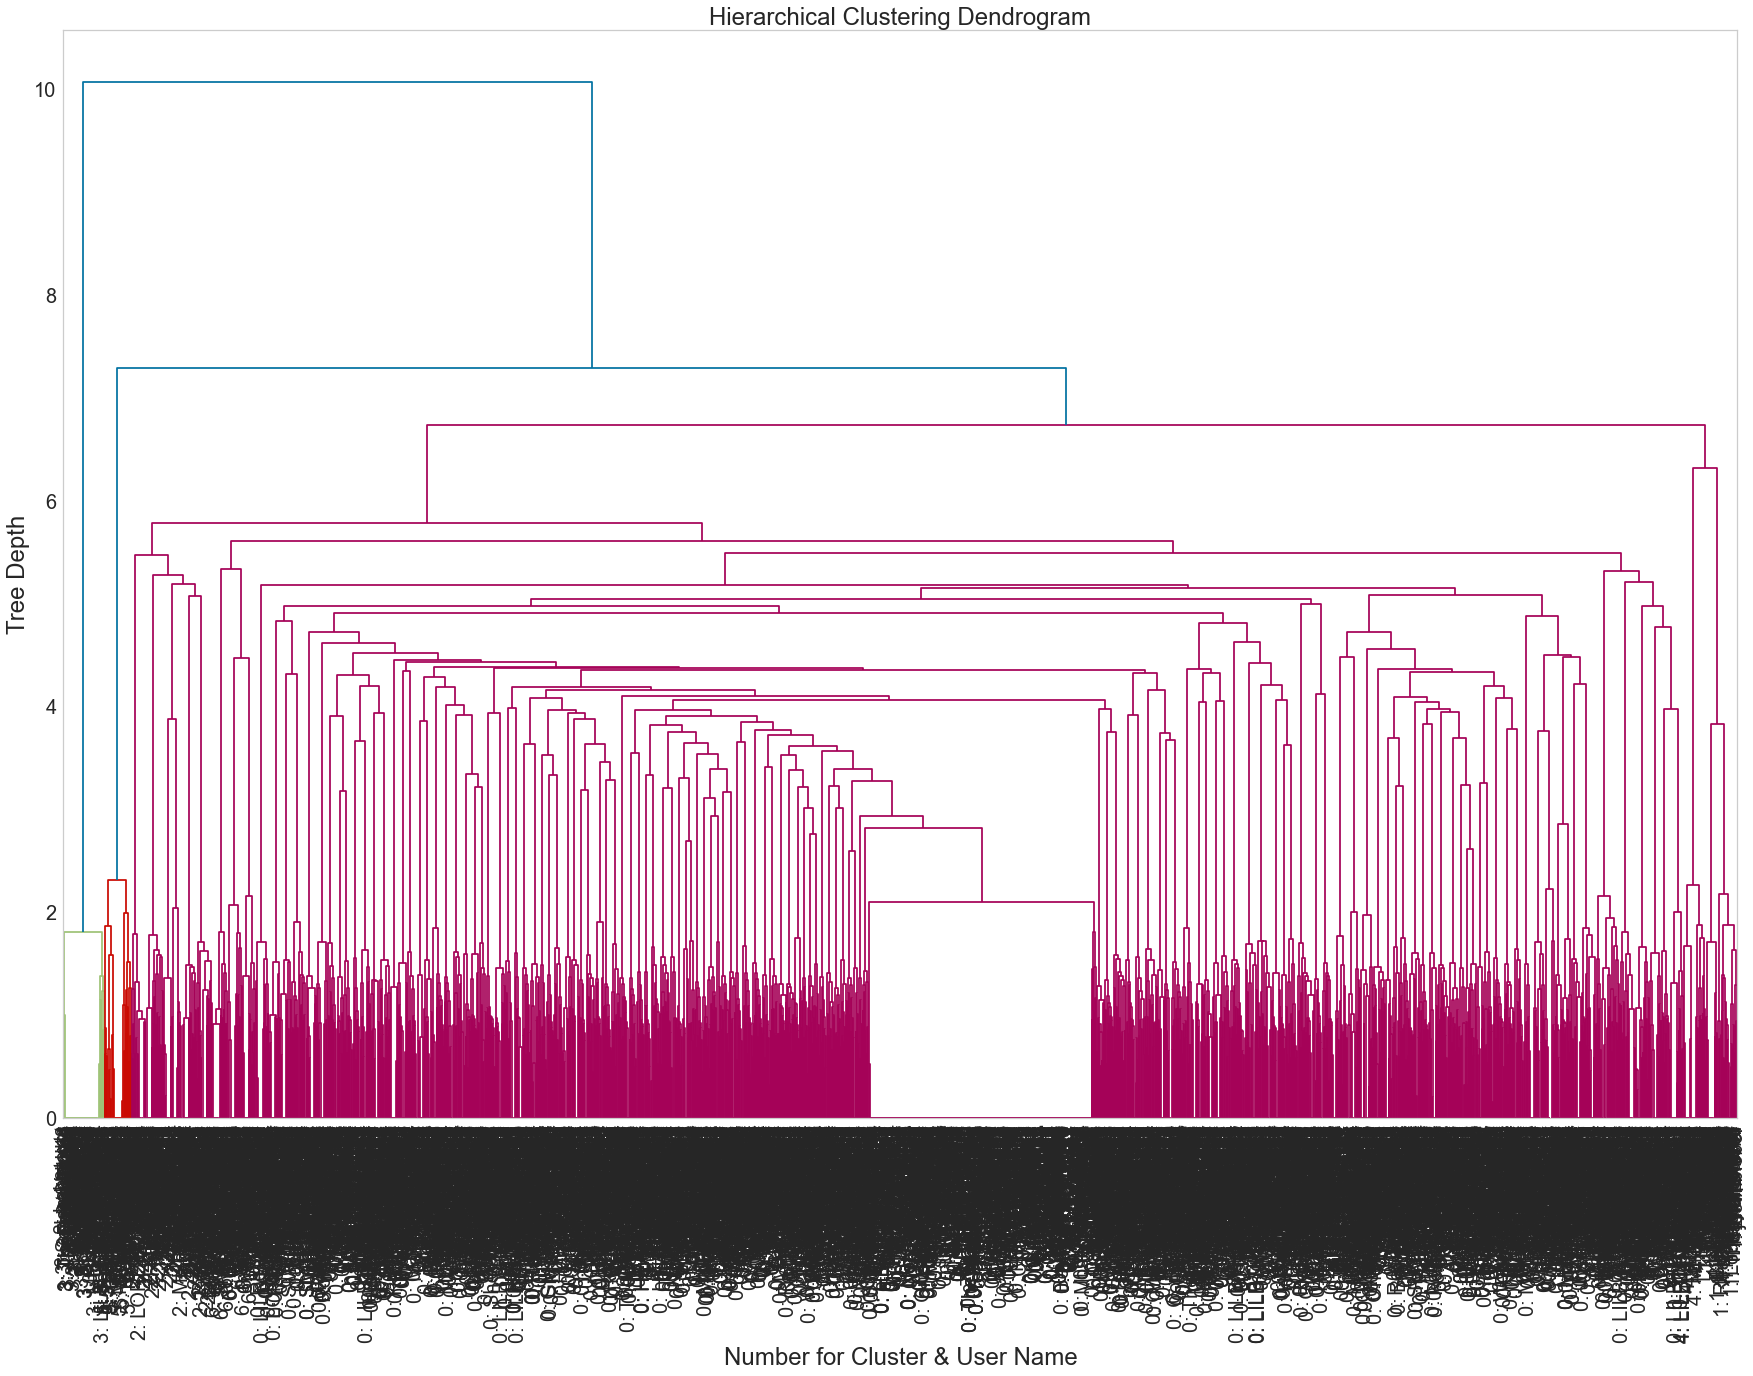

In [45]:
new_labels = getNewLabels(labels)
agg_dn = plot_dendrogram(X, new_labels)

In [87]:
labels2 = labels[:70]
X3 = X[:70]

print(labels)
print(np.unique(labels2))

[0 0 0 ... 0 0 0]
[0 1 2 3 4 5 6]


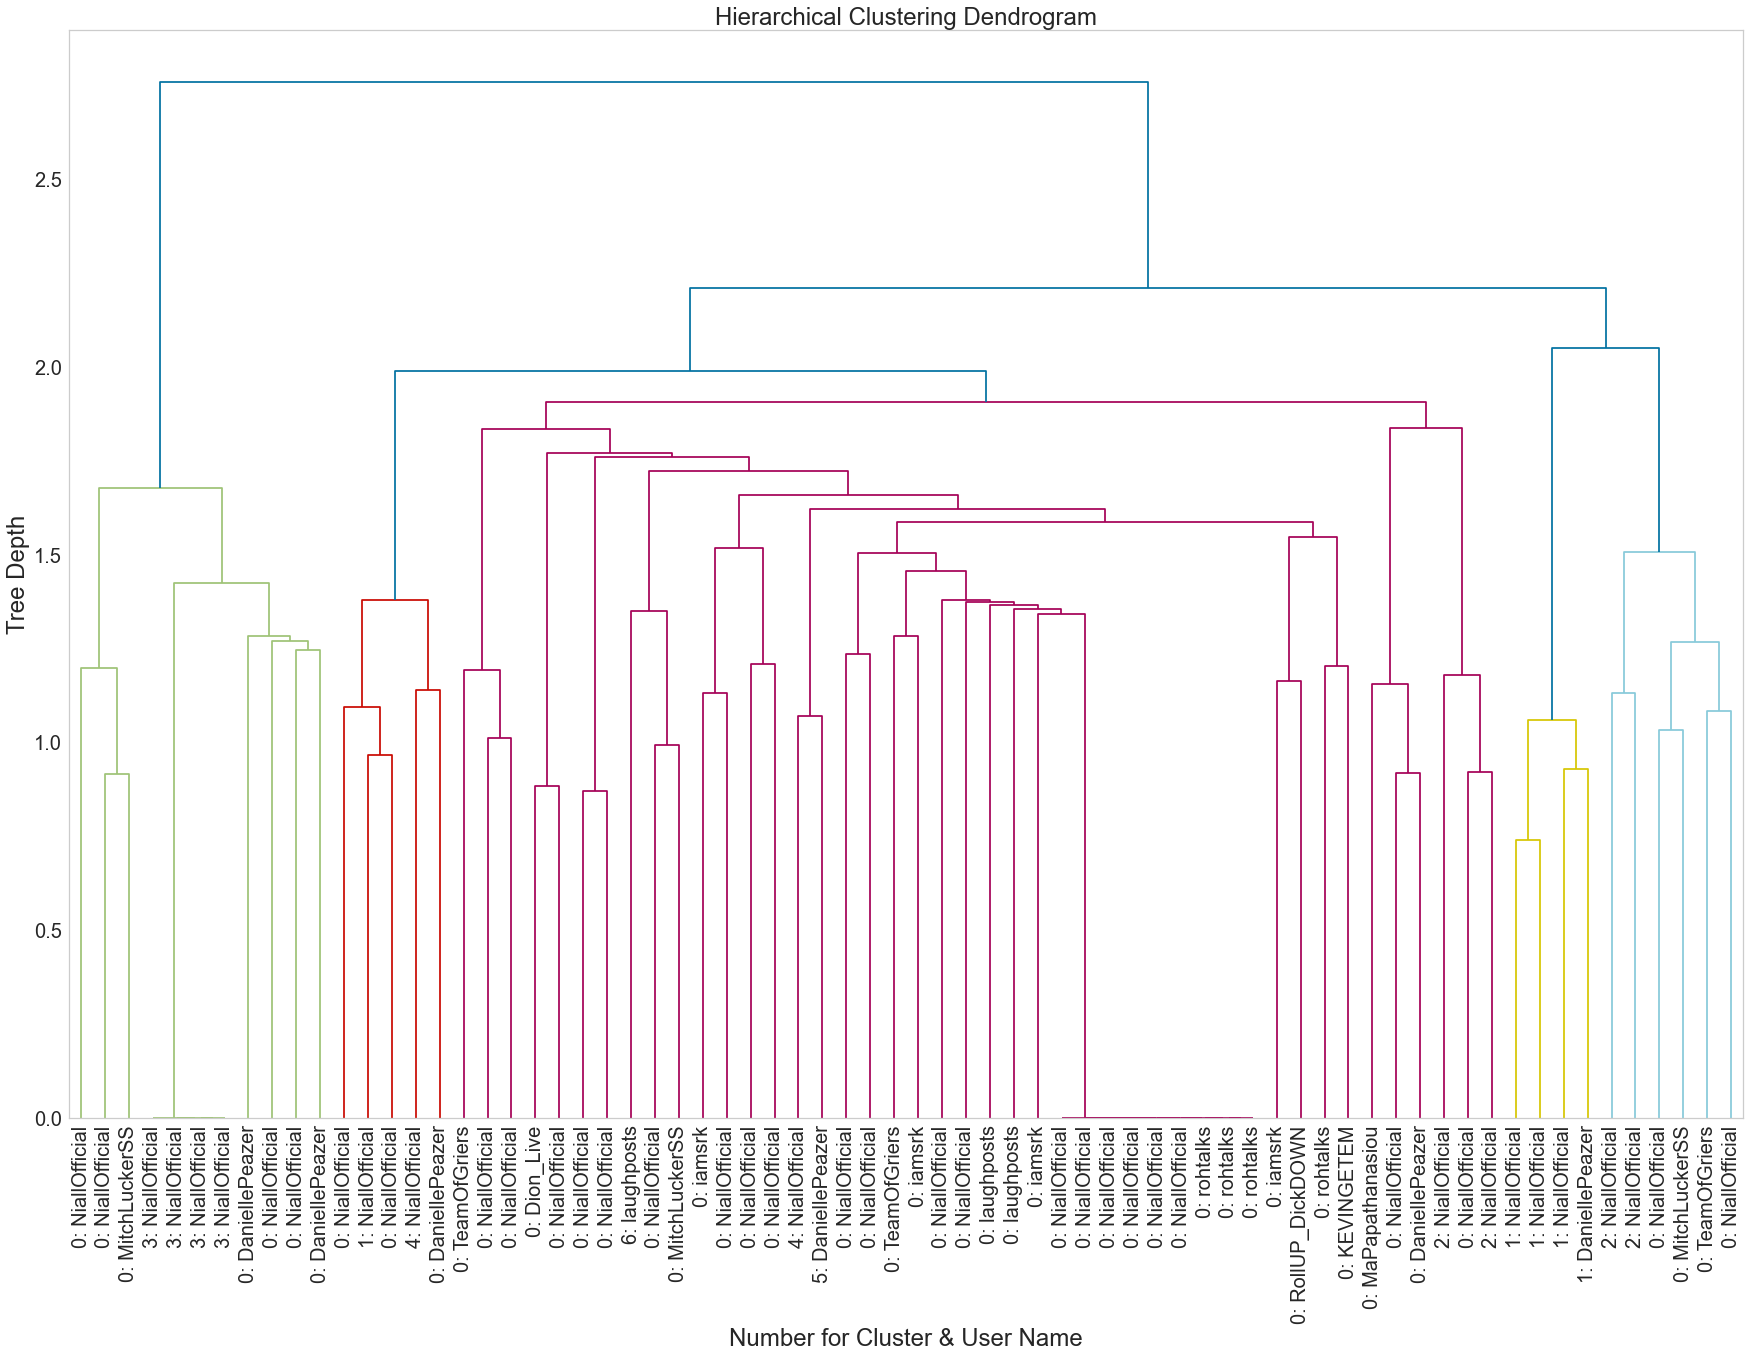

In [88]:
new_labels2 = getNewLabels(labels2)
agg_dn = plot_dendrogram(X3, new_labels2)

In [76]:
def get_node(agg_dn, num, X):
    new_labels = []
    new_tweets = agg_dn['ivl']
    print(new_tweets)
    new_arrary = []
    for direction, index in enumerate(new_tweets):
            index = int(index)
            print(index)
            new_arrary.append(X[index])
            #new_labels.append(str(index) + "\n" + df.loc[index]['user'])
            new_labels.append(df.loc[index]['user'])
    return (new_arrary, new_labels)

In [463]:
agg_dn['ivl'][:5]
plt.show()

In [459]:
#df plot_sub_dendrogram(X_den, X_labels)